# Estimating Home Values

Project goals:
- Perform EDA on Zillow dataset to see which features predict house prices well.
- Construct a ML Regression model that predicts property values.

## Imports

In [12]:
import wrangle as w
import explore as e
import model as m

import sys
import os
home_directory_path = os.path.expanduser('~')
sys.path.append(home_directory_path +'/utils')
from prepare_utils import split_data

%config InlineBackend.figure_format = 'retina'

from scipy import stats

In [13]:
# import warnings
# warnings.filterwarnings("ignore")

## Wrangle

- Acquiring zillow data form MySQL
- Clean data
    - keep only 2017 transactions
    - handle duplicate rows, id's, and homes in duplications
    - rename columns
    - handle missing values
    - filter out outliers from my data
        - 1-4 bathrooms
        - 1-6 bedrooms
        - age < 105
        - sqft < 5,000 and > 500
        - property_value < 1,500,000 and > 50_000
    - convert data to appropriate data types (floats, integers, etc.)

In [3]:
data = w.prep_zillow()
data.head()

,parcelid,id,bathrooms,bedrooms,sqft,fips,latitude,longitude,regionidcity,regionidzip,property_value,transaction_date,age,county
52520,12826780,1187175,2.0,3,1762,6037,33937685,-117996709,14634,96171,522000,2017-09-25,61,LA
52518,17239384,2968375,2.0,4,1612,6111,34300140,-118706327,27110,97116,67205,2017-09-21,52,Ventura
52517,11000655,673515,2.0,2,1286,6037,34245368,-118282383,12447,96284,354621,2017-09-20,76,LA
52508,12410050,2900077,1.0,2,1023,6037,33880374,-118112653,44116,96208,222739,2017-09-19,60,LA
52497,10867042,986237,2.0,3,2141,6037,34150146,-118490857,12447,96426,887003,2017-09-19,62,LA


**Note on data**:
- Homes from 3 California counties: LA, Orange, and Ventura

---
## Explore


Explore data in search of features that drive property value 

- Which features appear to relate to property value the most?
- Do home values vary significantly among the 3 counties?
- Do home values vary significantly among homes with x bedrooms and x bathrooms?

Key Insights:
- Strong Drivers of property value:
    - square footage
    - bathrooms
    - bedrooms
- Weak Drivers of property value:
    - county

Load training data to avoid data leakage and bias

In [4]:
train, _, _= split_data(data, validate_size=.15, test_size=.15, 
                         stratify_col='county', random_state=123)

train.columns

Index(['parcelid', 'id', 'bathrooms', 'bedrooms', 'sqft', 'fips', 'latitude',
       'longitude', 'regionidcity', 'regionidzip', 'property_value',
       'transaction_date', 'age', 'county'],
      dtype='object')

In [5]:
train = train[['bathrooms', 'bedrooms', 'sqft', 'property_value', 'age']]

**Which features appear to relate to property value the most?**

- Vizualize

`takeaway`

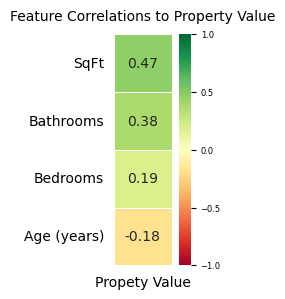

In [7]:
e.plot_target_heatmap(train)

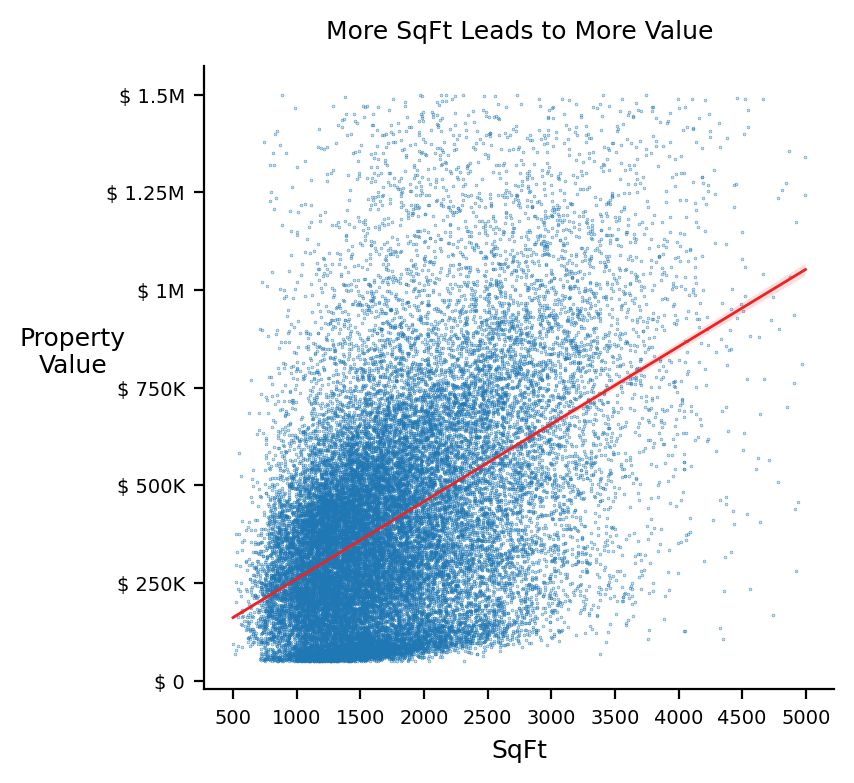

In [10]:
e.plot_sqft_to_value(train)

- Statistical test
    * Pearson correlation test
    * Hypotheses and significance level
        * $H_0$: There is no linear relationship between property value and square footage.
        * $H_a$: There is some linear relationship between property value and square footage.
        * $\alpha = .05$
- Verify Assumptions
    Normality: distributions are right skewed but we can bypass this with large sample sizes
    
Test:

In [15]:
pearson_r, p_val = stats.pearsonr(train['property_value'], train['sqft'])
print(f'Pearson R = {pearson_r}\nP value = {p_val}')

Pearson R = 0.4692160238974564
P value = 0.0


There's signicant evidence that there is a moderate positive correlation of around .47 between property value and square footage.

**Do home values vary significantly among the 3 counties?**



- Vizualize

`takeaway`

- Statistical test
    * ANOVA T-Test
    * Hypotheses and significance level
        * $H_0$: There is no difference in property value for homes in each county.
        * $H_a$: There is a difference in property value for homes in each county.
        * $\alpha = .05$
    * verify assumptions
        * Independence: Assumption met
        * Normality: Property values are right skewed, but assumption is met with large sample sizes
        * Equal Variances: Check with Levene's test
            * Variances are not equal, so we will set `equal_var=False` for the test

In [ ]:
stats.f_oneway(samp1, samp2, samp3)

* Run test
* Interpret the results of the test

- Insight

With a low p value, we can conclude that **property value is dependent on county**.

**Do home values vary significantly among those with X bedrooms?**



- Vizualize

`takeaway`

- Statistical test
    * ANOVA T-Test
    * Hypotheses and significance level
        * $H_0$: There is no difference in property value for homes in each county.
        * $H_a$: There is a difference in property value for homes in each county.
        * $\alpha = .05$
    * verify assumptions
        * Independence: Assumption met
        * Normality: Property values are right skewed, but assumption is met with large sample sizes
        * Equal Variances: Check with Levene's test
            * Variances are not equal, so we will set `equal_var=False` for the test

* Run test
* Interpret the results of the test

- Insight

With a low p value, we can conclude that **property value is dependent on county**.

**Do home values vary significantly among those with X bathrooms?**



- Vizualize

`takeaway`

- Statistical test
    * Independent (Two-Sample) T-Test (2-sided)
    * Hypotheses and significance level
        * $H_0$: There is no difference in property value for homes in each county.
        * $H_a$: There is a difference in property value for homes in each county.
        * $\alpha = .05$
    * verify assumptions
        * Independence: Assumption met
        * Normality: Assumption met with large sample sizes
        * Equal Variances: Check with Levene's test
            * Variances are not equal, so we will set `equal_var=False` for the test

* Run test
* Interpret the results of the test

- Insight

With a low p value, we can conclude that **property value is dependent on county**.

**Exploration Summary**

Key Insights:
- Strong Drivers of property value:
    - square footage
    - bathrooms
    - bedrooms
- Weak Drivers of property value:
    - county

Features to model on:
    - sqft and bathrooms


---
## Modeling

Run Linear Regression Models and evaluate their RMSE and coefficient of determination ($R^2$)

### Baseline 
* Dummy regression model (`sklearn.DummyRegressor`) which essentially predicts the mean property value for each input.

### Best Performing Model

- Pooled Linear Regression Model
- Features: sqft, bathrooms

### Perform best model on test data


### Modeling Wrap

* Model test score compared to the baseline
* Model insights

## Conclusion

### Summary
* summarize findings/drivers and answers
* state model performance compared to baseline

### Recommendations
* Recommend stakeholder actions
* Recommend models to use

### Next Steps
With more time, I would:
- Engineer features the categorize home location
    - using zipcodes or latitude and longitude
- Train a ML model on these features if they are strong drivers
- Run non-linear regression models
- Use non-linear feature scaling techniques